## Continuous Bag of Words (CBOW) from Scratch
In this implementation, I've re-created the famous **Continuous Bag of Words (CBOW)**, which is a model of Word2Vec to generate **word embeddings**. CBOW learns doing it trying to predict the **target (middle) word** of a sentence based on its surrounding words, known as **context words**. By leveraging patterns in the relationship between context and target words across a large text corpus, CBOW is actually able to learn word embeddings that represent semantic relationships between words.




In [1]:
import numpy as np

# Define the corpus
corpus = """We are about to study the idea of a computational process 
Computational processes are abstract beings that inhabit computers 
As they evolve , processes manipulate other abstract things called data 
The evolution of a process is directed by a pattern of rules called a program 
People create programs to direct processes 
In effect , we conjure the spirits of the computer with our spells"""
corpus = corpus.lower().split()  # and lowercase conversion

# Define the context window size and embedding dimension
CONTEXT_WINDOW_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 20  # Size of the word embeddings

We build a vocabulary (a unique set of words), then map each word to a unique index and vice versa for efficient lookups during training.

In [2]:
# Create vocabulary and mappings
vocab = set(corpus)
vocab_size = len(vocab)
print(vocab_size)

word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

print("Word to Index Dictionary:", word_to_index)

45
Word to Index Dictionary: {'other': 0, 'direct': 1, 'computational': 2, 'process': 3, 'conjure': 4, 'we': 5, 'evolution': 6, 'in': 7, 'with': 8, 'create': 9, 'processes': 10, 'of': 11, 'spells': 12, 'abstract': 13, 'they': 14, 'evolve': 15, 'data': 16, 'called': 17, 'a': 18, 'is': 19, 'are': 20, 'things': 21, 'programs': 22, 'spirits': 23, 'to': 24, 'idea': 25, 'that': 26, 'as': 27, 'about': 28, 'rules': 29, 'computer': 30, 'program': 31, ',': 32, 'by': 33, 'directed': 34, 'people': 35, 'the': 36, 'pattern': 37, 'our': 38, 'study': 39, 'inhabit': 40, 'effect': 41, 'beings': 42, 'computers': 43, 'manipulate': 44}


We define the One-hot encoding function which transform a given word into a one-hot vector, i.e. a vector with a single 1 at the index corresponding to that word in the vocabulary, and 0s elsewhere.

In [3]:
# One-hot encoding function (one-hot column vectors)
def one_hot_encode(word, word_to_index):
    one_hot = np.zeros((len(word_to_index), 1))  # Shape: (V, 1)
    one_hot[word_to_index[word], 0] = 1
    return one_hot

# Example usage
print(one_hot_encode('computational', word_to_index))

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


We can iterate through the entire corpus and form context-target pairs by extracting the target word and its surrounding context words based on the specified context window size.

In [4]:
context_target_pairs = []
# Generate context-target pairs
for i in range(CONTEXT_WINDOW_SIZE, len(corpus) - CONTEXT_WINDOW_SIZE):
    context = corpus[i - CONTEXT_WINDOW_SIZE:i] + corpus[i + 1:i + CONTEXT_WINDOW_SIZE + 1]
    target = corpus[i]
    context_target_pairs.append((context, target))

print("Context-Target Pairs:", context_target_pairs)

Context-Target Pairs: [(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea'), (['the', 'idea', 'a', 'computational'], 'of'), (['idea', 'of', 'computational', 'process'], 'a'), (['of', 'a', 'process', 'computational'], 'computational'), (['a', 'computational', 'computational', 'processes'], 'process'), (['computational', 'process', 'processes', 'are'], 'computational'), (['process', 'computational', 'are', 'abstract'], 'processes'), (['computational', 'processes', 'abstract', 'beings'], 'are'), (['processes', 'are', 'beings', 'that'], 'abstract'), (['are', 'abstract', 'that', 'inhabit'], 'beings'), (['abstract', 'beings', 'inhabit', 'computers'], 'that'), (['beings', 'that', 'computers', 'as'], 'inhabit'), (['that', 'inhabit', 'as', 'they'], 'computers'), (['inhabit', 'computers', 'they', 'evolve'], 'as'), (['computers', 'as', 'evolve', ',

This concludes the data preparation phase, we now move on to defining our network.

##### Model Architecture
The model architecture is quite simple. It consists of a network made of:

- A single hidden layer to generate embeddings.
- An output layer to predict the target word as a probability distribution.

where the input to the network is a one-hot vector of the context word.

We maintain two embedding matrices, $ W $ and $ W' $:

- $ W $ has dimensions $ V \times N $, where $ V $ is the vocabulary size and $ N $ is the embedding dimension.
- $ W' $ has dimensions $ N \times V $.


##### Forward Pass
Each context word vector is transformed into its corresponding dense word embedding by combining it with the embedding matrix $ W $:

$$
v_i = W^T \cdot x_i
$$

where $ v^{(i)} $ is the resulting word embedding for the $ i $-th context word.

Once the context word embeddings $ v_i $ are obtained, the hidden layer aggregates them. There are two possible aggregation methods:

1. **Averaging the embeddings**:
   
$$
\hat{v} = \frac{1}{2n} \sum_{i=1}^{2n} v_i
$$

2. **Summing the embeddings**:

$$
\hat{v} = \sum_{i=1}^{2n} v_i
$$

The aggregated context embedding $ \hat{v} $ is then combined with the second embedding matrix $ W' $, resulting in a $ V $-dimensional vector $ z $ (size $ V \times 1 $) representing the raw scores (logits) for each word in the vocabulary:

$$
z = W'^T \cdot \hat{v}
$$

These logits are then passed through the softmax function to obtain the probability distribution over all words in the vocabulary:

$$
\hat{y} = \text{softmax}(z)
$$

where each probability $ \hat{y}_i $ is calculated as:

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}}
$$


##### Loss Function

We use the **Cross-Entropy loss** to measure the error between the predicted probability distribution $ \hat{y} $ and the actual target word one-hot vector $ y $:

$$
L = -\sum_{i=1}^{m} y_i \log(\hat{y}_i)
$$


##### Backward Pass

From the neural network chapter in the Theory, we found that the explict-form error formulation of the categorical cross-entropy loss simplifies to:

$$
\frac{\partial J}{\partial z^{[L]}} = s - y
$$
where $ s $ is the output obtained from softmax (i.e., the predicted probability distribution) and $ y $ is the one-hot target vector. To align with our notation, we denote $ s $ as $ \hat{y} $, so the error becomes:

$$
\text{error} = \hat{y} - y
$$

Now we also need to find the explicit-form gradient formulations with respect to $ W $ and $ W' $. Here I report directly them (without showing how I obtained them, since I think is not so important to lost time in the derivation ... however after having read the neural network chapter you should have an idea of how to obtain them):

- The gradient of the loss with respect to $ W' $ is:

    $$
    \Delta W' = \hat{v} \otimes \text{error}
    $$ 
    where $ \otimes $ denotes the outer product.

- The gradient of the loss with respect to $ W $ is:
    
    - In case we *averaged* the emebeddings:

    $$
    \Delta W = \frac{1}{2n} \sum_{i=1}^{2n} x_i \otimes (W' \cdot \text{error})
    $$

    - In case we *summed* the emebeddings:
    $$
    \Delta W = \sum_{i=1}^{2n} x_i \otimes (W' \cdot \text{error})
    $$

    For each context word $ x_i $, we compute the contribution of $ W' \cdot \text{error} $ to update the corresponding row in $ W $. 
    
    **Note**: Since the only change between the two is a factor $ \frac{1}{2n} $ we can also simply not consider and use directly the first expression for both cases.

Once we have the gradients we can update $ W $ and $ W' $ using the SGD update rule:

$$
W \leftarrow W - \eta \Delta W
$$

$$
W' \leftarrow W' - \eta \Delta W'
$$

where $ \eta $ is the learning rate.


In [5]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=0)


# CBOW model class
class CBOW:
    def __init__(self, vocab_size, embedding_dim):
        # Initialize weights for embedding matrices
        self.W1 = np.random.randn(vocab_size, embedding_dim) # W
        self.W2 = np.random.randn(embedding_dim, vocab_size) # W'
    
    def forward(self, context_words):
        # Project one-hot encoded context words to embedding space, obtaining our dense word embeddings
        v_i = np.dot(self.W1.T, context_words)
        # Perform aggregation operation to obtain a single aggregate embedding
        v = np.mean(v_i, axis=1) # average of context word embeddings
        #v = np.sum(v_i, axis=1) # sum of context word embeddings
        # Calculate the vector z representing the logits
        z = np.dot(self.W2.T, v)
        # Apply softamx to obtain in output probabilities over the dictionary
        y_hat = softmax(z)
        return y_hat, v

    def backward(self, context_words, y, y_hat, v, learning_rate=0.01):
        # Calculate error
        error = y_hat - y
        
        # Gradient for W2
        dW2 = np.outer(v, error)
        
        # Gradient for W1
        dW1 = np.zeros_like(self.W1)
        for context_word in context_words:
            dW1 += np.outer(context_word, np.dot(self.W2, error))

        # Update weights (SGD)
        self.W2 -= learning_rate * dW2  # Update W2
        self.W1 -= learning_rate * dW1  # Update W1


In [6]:
# Instantiate the CBOW model
cbow_model = CBOW(vocab_size, EMBEDDING_DIM)

learning_rate = 0.01
num_epochs = 50

# Training
for epoch in range(num_epochs):
    total_loss = 0
    for context, target in context_target_pairs:
        # One-hot encode context and target
        context_words = np.array([one_hot_encode(word, word_to_index) for word in context])
        target_word = one_hot_encode(target, word_to_index)

        # Forward pass
        output, v = cbow_model.forward(context_words)

        # Compute loss
        loss = -np.sum(target_word * np.log(output + 1e-8)) # Here a small constant 1e-8 is added to avoid log(0), which would result in NaN values.
        total_loss += loss

        # Backward pass
        cbow_model.backward(context_words, target_word, output, v, learning_rate)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/50, Loss: 389.0667
Epoch 2/50, Loss: 362.2056
Epoch 3/50, Loss: 338.5308
Epoch 4/50, Loss: 317.5251
Epoch 5/50, Loss: 298.7448
Epoch 6/50, Loss: 281.8162
Epoch 7/50, Loss: 266.4332
Epoch 8/50, Loss: 252.3489
Epoch 9/50, Loss: 239.3670
Epoch 10/50, Loss: 227.3316
Epoch 11/50, Loss: 216.1189
Epoch 12/50, Loss: 205.6302
Epoch 13/50, Loss: 195.7861
Epoch 14/50, Loss: 186.5225
Epoch 15/50, Loss: 177.7867
Epoch 16/50, Loss: 169.5354
Epoch 17/50, Loss: 161.7320
Epoch 18/50, Loss: 154.3456
Epoch 19/50, Loss: 147.3493
Epoch 20/50, Loss: 140.7189
Epoch 21/50, Loss: 134.4329
Epoch 22/50, Loss: 128.4709
Epoch 23/50, Loss: 122.8143
Epoch 24/50, Loss: 117.4454
Epoch 25/50, Loss: 112.3474
Epoch 26/50, Loss: 107.5048
Epoch 27/50, Loss: 102.9030
Epoch 28/50, Loss: 98.5285
Epoch 29/50, Loss: 94.3688
Epoch 30/50, Loss: 90.4124
Epoch 31/50, Loss: 86.6485
Epoch 32/50, Loss: 83.0670
Epoch 33/50, Loss: 79.6587
Epoch 34/50, Loss: 76.4145
Epoch 35/50, Loss: 73.3260
Epoch 36/50, Loss: 70.3854
Epoch 37/5

Let's see what the model learnt by passing to it some context words and checking what target word we get

In [7]:
# Testing the CBOW model
context = ['people', 'create', 'to', 'direct']

context_words = np.array([one_hot_encode(word, word_to_index) for word in context])
output, _ = cbow_model.forward(context_words)
predicted_word = index_to_word[np.argmax(output)]

print(f"Context: {context}")
print(f"Prediction: {predicted_word}")

Context: ['people', 'create', 'to', 'direct']
Prediction: programs


Great! We obtain exactly the target word we aspected to obtain.

Now, as last thing let's also see what our embedding representation looks like. Remeber that to obtain the embedding of a given word we simply need to extract the corresponding row from $ W $

In [8]:
# Get the index of the word "programs"
word = "programs"

# Extract the embedding vector for "programs" from W1
word_embedding = cbow_model.W1[word_to_index[word]] # Extract the corresponding row from W1

print(f"Word: {word}")
print(f"Embedding:\n{word_embedding}")

Word: programs
Embedding:
[-1.05471451  0.95608153  1.05837788  0.11159528  1.41323136  0.17162232
  1.19818983  0.30139875  0.49395192 -0.9373227  -0.40122157 -0.10714656
 -0.77123862  0.27404753 -1.22874273 -0.37330114  1.71865781  1.27789394
  1.18312727 -1.03202785]


This concludes the implementation. Below there is an extra implementation of the same, but more efficient that I suggest you to read.

---
## CBOW in PyTorch: Efficient Implementation
Below is an efficient implementation of the CBOW model in PyTorch, improving on the previous version. The core logic remains the same, but a few optimizations have been made:

- **Use of the nn.Embedding Layer**: Instead of explicitly maintaining and using two embedding matrices, the `nn.Embedding layer` is employed.
In Pytorch the **`nn.Embedding layer`** maps vocabulary indices directly to dense embeddings using optimized lookups, avoiding the need to construct one-hot vectors. Moreover, we know that One-hot encoding creates large sparse vectors, which are computationally expensive to handle especially for large vocabularies, therefore using this method that adopts indices we directly avoid this overhead.

- **Direct Handling of Indices without One-hot Encoding**:
Both context words and target words are represented as indices and passed directly to the embedding layer, which maps each index to a dense vector (embedding).

- **Loss Function Change**:
A **LogSoftmax** combined with **NLLLoss** is used instead of using the standard **Softmax** with **Cross-Entropy Loss** (this aspect is better detailed later).

- **Automatic Differentiation**:
Gradients are computed automatically using PyTorch’s autograd. There’s no need to explicitly write the explicit-form derivatives, as they are handled internally.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

The data preparation phase is the same expect that we don't transform each word into a one-hot vector anymore, but instead we use a single vector where each element contains directly the index of the considered context word:

In [10]:
# Function to create a context vector from a list of words using a word-to-index mapping
def make_context_vector(context, word_to_index):
    idxs = [word_to_index[w] for w in context]  # Convert words to their corresponding indices
    return torch.tensor(idxs, dtype=torch.long) # convert it into a tensor

context, target = context_target_pairs[0]
print(context)
print(target)

context_vector = make_context_vector(context, word_to_index)
print(context_vector)

['we', 'are', 'to', 'study']
about
tensor([ 5, 20, 24, 39])


Said that we can get straight into the model architecture

In [11]:
# Define the Continuous Bag of Words (CBOW) model
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)

    # Define the forward pass
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        #agg_embed = torch.mean(embeds, dim=0).view(1, -1)  # Average embeddings of context words
        agg_embed = sum(embeds).view(1, -1) # Sum embeddings of context words
        out = self.linear(agg_embed)
        out = self.activation_function(out)
        return out

    # Helper function to get the embedding of a specific word
    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_index[word]])  # Convert word to index
        return self.embeddings(word).view(1, -1)  # Return the embedding

In [12]:
# Instantiate the model, loss function, and optimizer
model = CBOW(vocab_size, EMBEDDING_DIM)
loss_function = nn.NLLLoss()  # Negative Log Likelihood Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training
for epoch in range(50):
    total_loss = 0
    # for each context-target pair
    for context, target in context_target_pairs:
        context_vector = make_context_vector(context, word_to_index)  # convert context to tensor

        log_probs = model(context_vector)  # Forward pass

        # Compute the loss
        total_loss += loss_function(log_probs, torch.tensor([word_to_index[target]]))

    # Backpropagation and optimization
    optimizer.zero_grad()  # clear gradients
    total_loss.backward()  # backpropagate the loss
    optimizer.step()  # update the model parameters

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 265.0202
Epoch 2/50, Loss: 212.2580
Epoch 3/50, Loss: 174.9273
Epoch 4/50, Loss: 146.7713
Epoch 5/50, Loss: 124.2545
Epoch 6/50, Loss: 105.9549
Epoch 7/50, Loss: 91.1215
Epoch 8/50, Loss: 79.1161
Epoch 9/50, Loss: 69.3509
Epoch 10/50, Loss: 61.3484
Epoch 11/50, Loss: 54.7285
Epoch 12/50, Loss: 49.1913
Epoch 13/50, Loss: 44.5070
Epoch 14/50, Loss: 40.5018
Epoch 15/50, Loss: 37.0451
Epoch 16/50, Loss: 34.0372
Epoch 17/50, Loss: 31.4015
Epoch 18/50, Loss: 29.0777
Epoch 19/50, Loss: 27.0181
Epoch 20/50, Loss: 25.1840
Epoch 21/50, Loss: 23.5437
Epoch 22/50, Loss: 22.0710
Epoch 23/50, Loss: 20.7442
Epoch 24/50, Loss: 19.5446
Epoch 25/50, Loss: 18.4567
Epoch 26/50, Loss: 17.4671
Epoch 27/50, Loss: 16.5642
Epoch 28/50, Loss: 15.7382
Epoch 29/50, Loss: 14.9805
Epoch 30/50, Loss: 14.2838
Epoch 31/50, Loss: 13.6415
Epoch 32/50, Loss: 13.0480
Epoch 33/50, Loss: 12.4984
Epoch 34/50, Loss: 11.9883
Epoch 35/50, Loss: 11.5139
Epoch 36/50, Loss: 11.0718
Epoch 37/50, Loss: 10.6591
Epoc

#### Note: LogSoftmax + NLLLoss vs. Softmax + Cross-Entropy Loss

##### LogSoftmax:

**LogSoftmax** is a variant of the **Softmax** function where it directly applies the logarithm to the output probabilities, ensuring that the function returns the log of the probabilities rather than the probabilities themselves. Mathematically, it’s defined as:

$$
\text{LogSoftmax}(z_i) = \log \left( \frac{\exp(z_i)}{\sum_j \exp(z_j)} \right)
$$

Where $ z_i $ represents the raw logits (i.e., unnormalized output values from the model).

This transformation outputs the log probabilities directly, and as a result, there is no need to apply a separate logarithm after applying Softmax.

##### NLLLoss:

The **Negative Log-Likelihood Loss (NLLLoss)** expects log probabilities as input, and calculates the loss using the following formula:

$$
\text{NLLLoss}(y, \hat{y}) = - \sum_{i=1}^{m} y_i \cdot \hat{y}_i
$$

Where:
- $ y_i $ is the **true label** (usually represented as either a one-hot encoded vector or as an index of the correct class).
- $ \hat{y}_i $ is the **log probability** of the predicted class, which is obtained by applying **LogSoftmax** to the raw logits.

##### Why use LogSoftmax + NLLLoss?

The **logarithm** in **LogSoftmax** ensures that the output values are bounded and less prone to the numerical instability that arises from exponentiating large logits. In simpler terms, **LogSoftmax + NLLLoss** is more numerically stable because the logarithm is applied directly to the logits before computing the loss, rather than after applying the Softmax function.

##### Alternative: Cross-Entropy Loss (CE)

Another equivalent approach is to **avoid using LogSoftmax** in the output layer and instead directly use **Cross-Entropy Loss (CCE)** implementation of PyTorch:

$$
\text{CE}(y, \hat{y}) = - \sum_{i=1}^{m} y_i \cdot \log \left( \frac{\exp(\hat{y}_i)}{\sum_j \exp(\hat{y}_j)} \right)
$$
which combines Softmax and the Cross Entropy loss (or equivalentelly LogSoftamx and NLLLoss) into a single operation.


---

Again let's test this making the model predict a target word given some context words

In [13]:
# Testing
context = ['people', 'create', 'to', 'direct']  # Example context
context_vector = make_context_vector(context, word_to_index)  # Convert context to tensor
prediction = model(context_vector)  # Make a prediction

#print(f'Corpus: {" ".join(corpus)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {index_to_word[torch.argmax(prediction[0]).item()]}')  # Predicted word


Context: ['people', 'create', 'to', 'direct']

Prediction: programs


Word Embedding:

In [14]:
res = model.get_word_emdedding("programs")
print(res)

tensor([[ 0.2445, -0.2056, -1.3911, -1.1026,  0.5334,  0.0448,  1.2896, -0.7870,
          0.5389,  1.8773,  1.1999,  0.1601, -0.5281,  2.1038, -0.4116, -0.0130,
          0.2523,  0.4683,  0.5941,  0.9658]], grad_fn=<ViewBackward0>)


---
#### Word2Vec with Gensim library
**`Gensim’s models.Word2Vec`** provides a robust and efficient way to implement the word2vec family of algorithms, leveraging highly optimized C routines, efficient data streaming, and Pythonic interfaces. It includes the two Word2Vec primary algorithms, skip-gram and continuous bag-of-words (CBOW), both of which can utilize hierarchical softmax or negative sampling to learn high-quality word embeddings.

With Gensim, it’s straightforward to create your own Word2Vec model. For instance, by defining a dataset of tokenized sentences, you can train a CBOW model (or skip-gram, based on the configuration) tailored to your specific text corpus. Once trained, this model can be used to compute **word similarities**,  find words **most similar** to a given word, and perform tasks like **word analogy** or "**odd one out**", where the model identifies the word that doesn't belong in a set.

In [ ]:
# uncomment this just the first time to download the following library inside the ml_venv
"""
! pip install gensim
"""

In [ ]:
# https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import Word2Vec

# Define your own dataset (list of tokenized sentences)
sentences = [
    ['Rome', 'is', 'the', 'capital', 'of', 'the', 'country', 'Italy'],
    ['London', 'is', 'the', 'capital', 'of', 'the', 'country', 'UK'],
    ['Giuseppe', 'likes', 'play', 'football'],
    ['Luigi', 'likes', 'play', 'tennis'],
    ['Giovanni', 'likes', 'play', 'tennis'],
    ['Giuseppe', 'is', 'friend', 'of', 'Luigi']
]

# Own Word2Vector Model
# training word2vec on 3 sentences
own_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)


# using the trained model
print("Similarity between 'Rome' and 'London':", own_model.wv.similarity('Rome', 'London'))
print("Similarity between 'Luigi' and 'Giovanni':", own_model.wv.similarity('Luigi', 'Giovanni'))

# finding the most similar words
print("Most similar words to 'play':", own_model.wv.most_similar('play'))

# odd one out
print("Odd one out fot sentence 'Rome, London, Luigi':", own_model.wv.doesnt_match(['Rome', 'London', 'Luigi']))

# access word vectors
print("Vector for 'Rome':", own_model.wv['Rome'][:5])  # First 10 dimensions of the vector

### Pre-trained Word2Vec Model
We can see that the results we got from our own model are good, but not so exceptional. This is expected, as we used a very limited number of sentences, which restricts the model's ability to capture deeper semantic relationships between words. To achieve better results, we would need a much larger corpus of text and more intensive training.

To demonstrate the potential of a more powerful model, we can turn to a pre-trained model that has been trained on a vast corpus and has learned richer word representations. In this case, we will consider the pre-trained **`word2vec-google-news-300`** model, which has been trained on a large collection of news articles. By using such a pre-trained model, we gain access to high-quality word vectors that reflect a broader understanding of word meanings.
Gensim makes it simple to download and load this pre-trained model using the **`api.load function`**. Once we load the model, we can perform various tasks such as checking word similarities, exploring word analogies, and performing "odd one out" task, all with much richer and more accurate results than those obtained from our limited custom model.

**Note**: The pretrained model occupies 1662.8MB !

In [ ]:
# Download the pre-trained model using Gensim's API
import gensim.downloader as api

google_news_model = api.load('word2vec-google-news-300')  # This automatically downloads and loads the model

In [ ]:
# getting word vector of a word
print(f"Vector for 'Sunday': {google_news_model['Sunday'][:10]}...")  # Display first 10 dimensions
print("Original size: ", len(google_news_model['Sunday']))

#printing most similar
print("\nWords most similar to Sunday':", google_news_model.most_similar("Sunday"))

#performing king queen magic
print("\n[king]-[man]+[woman]≈", google_news_model.most_similar(positive=['woman', 'king'], negative=['man']))

#picking odd one out
print("\nPicking odd one out on the sentence 'breakfast cereal dinner lunch' results in:", google_news_model.doesnt_match("breakfast cereal dinner lunch".split()))

#printing similarity index
print("\nSimilarity between 'woman' and 'man':", google_news_model.similarity('woman', 'man'))


Vector for 'Sunday': [ 0.09375     0.07861328  0.01696777 -0.2890625   0.09423828  0.08007812
  0.05566406 -0.203125    0.09423828  0.14648438]...
Original size:  300

Words most similar to Sunday': [('Saturday', 0.9140512347221375), ('Friday', 0.8278788328170776), ('Monday', 0.8032042384147644), ('Thursday', 0.7955337166786194), ('Wednesday', 0.7883671522140503), ('Tuesday', 0.7824150919914246), ('evening', 0.6151020526885986), ('afternoon', 0.6117346882820129), ('Thurday', 0.6072263121604919), ('Feb.', 0.598168671131134)]

[king]-[man]+[woman]≈ [('queen', 0.7118193507194519), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321839332581), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.5181134343147278), ('sultan', 0.5098593831062317), ('monarchy', 0.5087411999702454)]

Picking odd one out on the sentence 'breakfast cereal dinner lunch' results in: cereal

Similarity between 'w

An interesting thing we can do is visualize the word vectors of Google's Word2Vec model. To achieve this, we can use a popular dimensionality reduction technique called t-SNE to reduce the dimensionality of the vector space from 300 dimensions to just 2. This reduction allows us to plot the word vectors on a 2D plane for easier interpretation.

You might ask, "Why should I use t-SNE if I'm already familiar with PCA?". To answer this question et's briefly talk about t-SNE.
**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is a non-linear dimensionality reduction algorithm that aims to find patterns in data by analyzing the similarity between data points. The similarity between two points is computed as the conditional probability that one point (A) would choose another point (B) as its neighbor. t-SNE then seeks to minimize the difference between these conditional probabilities in the higher-dimensional space and the lower-dimensional space (typically 2D or 3D). This allows for a more accurate and meaningful representation of data points in a lower-dimensional space, where similar points are placed close to each other, and dissimilar points are positioned farther apart. This approach makes t-SNE particularly useful for visualizing complex data, such as word embeddings, by preserving the relationships between points in a way that is easy to interpret.
Therefore, once obtained the reduced 2-dimensional word vectors we can plot them on a 2D plane, where the relative distances between points reflect the semantic similarity of the words they represent.

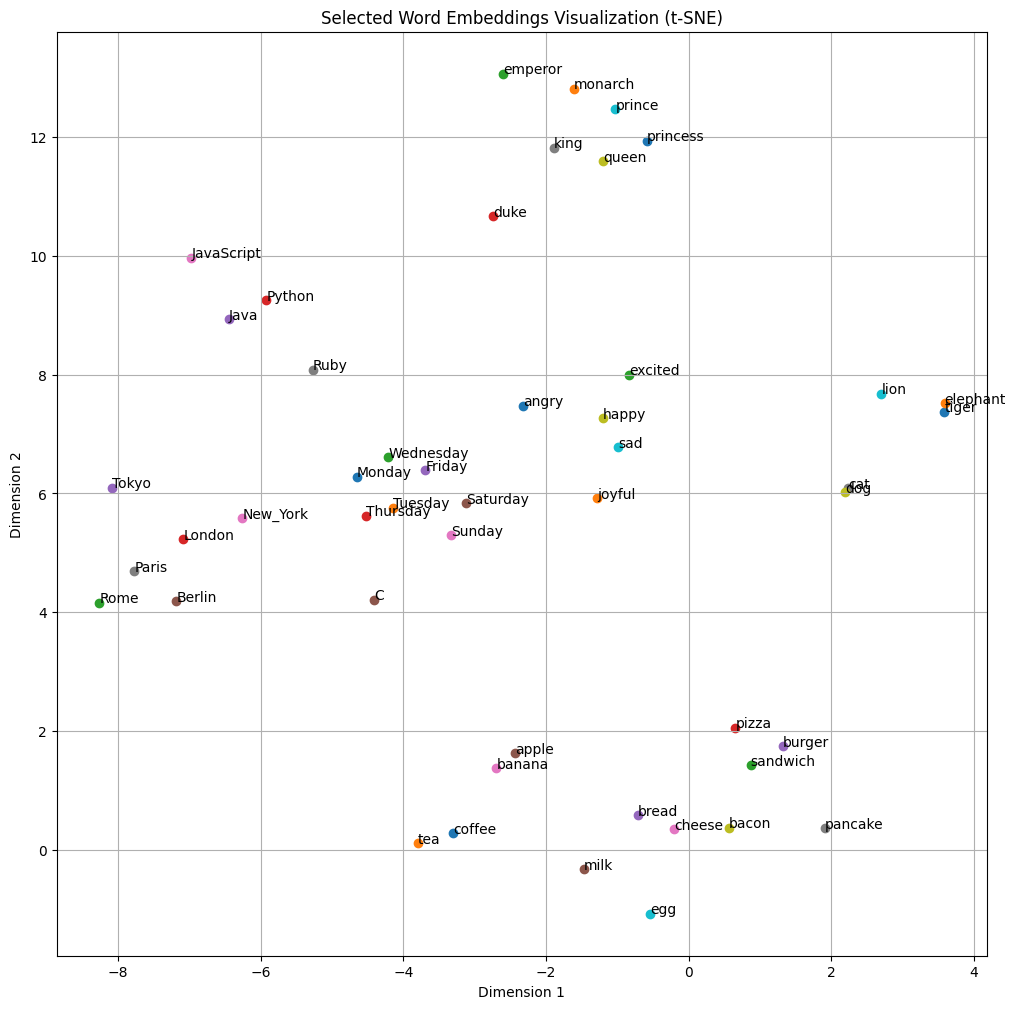

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

# Define a curated list of words for clustering
selected_words = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', # Days
    'king', 'queen', 'prince', 'princess', 'monarch', 'emperor', 'duke', # Royality
    'bread', 'milk', 'cheese', 'pancake','bacon', 'egg', 'coffee', 'tea', 'sandwich', 'pizza', 'burger', 'apple', 'banana', # Food
    'cat', 'dog', 'lion', 'tiger', 'elephant',  # Animals
    'Rome', 'London', 'Tokyo', 'Berlin', 'New_York', 'Paris',  # Cities
    'happy', 'sad', 'angry', 'joyful', 'excited',  # Emotions
    'Python', 'Java', 'C', 'JavaScript', 'Ruby',  # Programming languages
]

# Retrieve word vectors for the selected words
word_vectors = np.array([google_news_model[word] for word in selected_words])

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
reduced_vectors = tsne.fit_transform(word_vectors)

# Plot the selected words
plt.figure(figsize=(12, 12))
for i, word in enumerate(selected_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=10)
plt.title("Selected Word Embeddings Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

Another interesting thing we can do is to plot similar words of a given set of words. We can control the number of similar words in t-SNE using the `perplexity` parameter.


**`perplexity`** is a critical hyperparameter in t-SNE that determines the balance between local and global aspects of the data. A lower perplexity focuses more on local data points, while a higher perplexity emphasizes the broader structure of the data. By adjusting this parameter, we can fine-tune the representation of clusters in the reduced space. 


After applying t-SNE with a setted perplexity, we are able to visualize meaningful clusters in the vector space, showing how semantically related words are grouped together. Isn't it fascinating to see how t-SNE reduces the dimensionality from 300 to 2 while retaining these cluster properties so accurately?

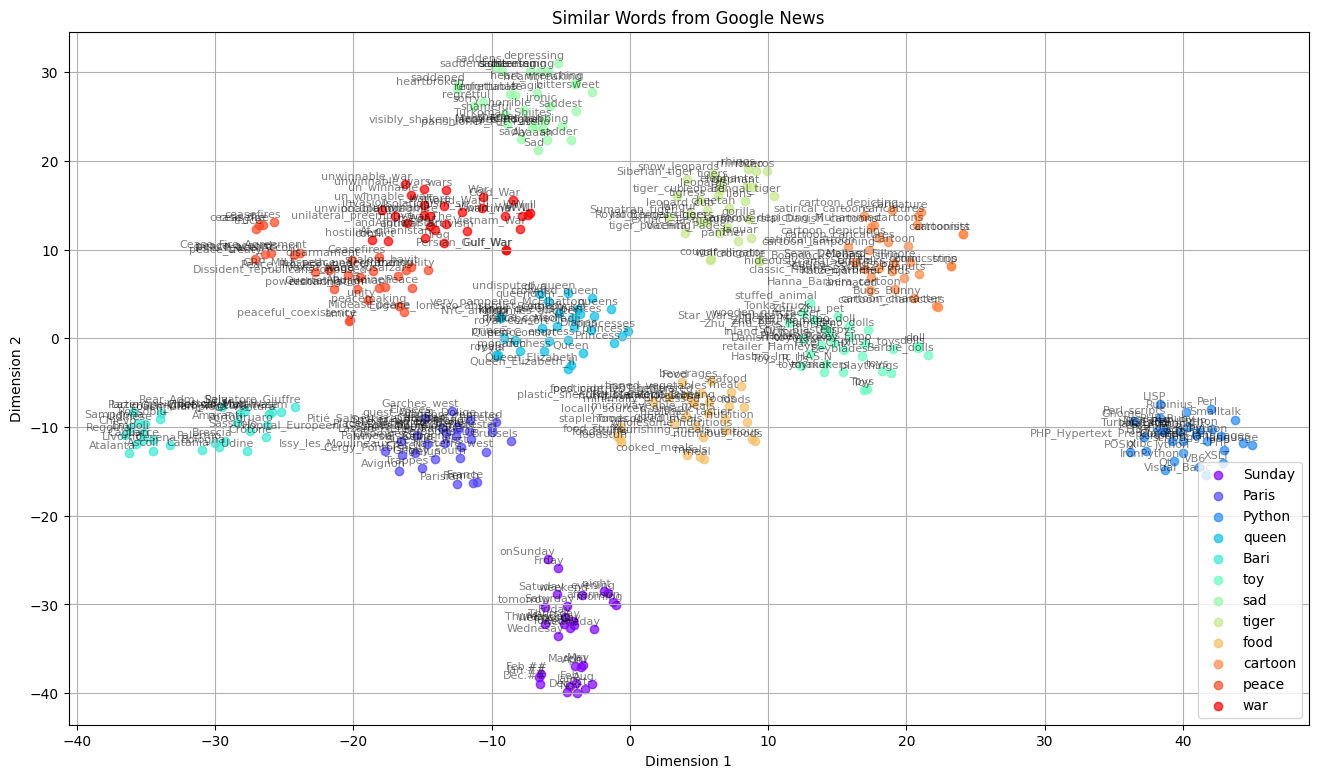

In [ ]:
# Select words to visualize
keys = ['Sunday', 'Paris', 'Python', 'queen', 'Bari', 'toy', 'sad', 'tiger', 'food', 'cartoon', 'peace', 'war']
PERPLEXITY = 15 # Perplexity parameter

# Prepare data for t-SNE
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    try:
        # Get similar words and their vectors
        for similar_word, _ in google_news_model.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(google_news_model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    except KeyError:
        print(f"'{word}' not in the vocabulary!")

# Convert to NumPy arrays
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

# Apply t-SNE for dimensionality reduction
tsne_model = TSNE(perplexity=PERPLEXITY, n_components=2, init='pca', max_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Plotting function
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', fontsize=8)
    plt.legend(loc='lower right')
    plt.title("Similar Words from Google News")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Visualize similar words
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)


---

#### Visualizing Word Embeddings with TensorFlow's Embedding Projector

For an interactive exploration of word embeddings, you can check out [TensorFlow's Embedding Projector](https://projector.tensorflow.org/). This tool provides a visual representation of high-dimensional embeddings, such as Word2Vec, by projecting them into a 2D or 3D space. It allows you to compare different dimensionality reduction techniques, including PCA, t-SNE and UMAP, helping you understand how each method preserves relationships between words.

On the right-hand side, there's a search menu where you can look up specific words and retrieve their most similar counterparts based on a chosen similarity measure—either Euclidean distance or cosine similarity.